# 一维卡尔曼滤波器

In [2]:
%matplotlib inline

import lean.book_format as book_format
book_format.set_style()

现在我们了解了离散贝叶斯滤波器和高斯，我们准备实现卡尔曼滤波器。我们将完全按照离散贝叶斯滤波器的方式执行此操作,而不是从方程开始，我们将根据对问题的推理逐步开发代码。

“一维”表示滤波器仅跟踪一个状态变量，例如 x 轴上的位置。在随后的章节中，我们将学习一种更通用的多维滤波器形式，它可以同时跟踪许多状态变量，例如位置、速度和加速度。回想一下，我们在g-h滤波器中使用速度来获得比单独跟踪位置更好的估计值。卡尔曼滤波器也是如此。

那么，为什么不直接跳入滤波器的多维形式呢？老实说，数学很困难，我开发滤波器的直观方法开始崩溃。这种数学模糊了允许卡尔曼滤波器工作的相当简单的原理。

因此，在本章中，我们将学习如何使用高斯来实现贝叶斯滤波器。这就是卡尔曼滤波器的全部内容 - 使用高斯的贝叶斯滤波器。在下一章中，我们将切换到多维形式，卡尔曼滤波器的全部力量将被释放！

## 一、问题描述



与离散贝叶斯滤波器一章一样，我们工作中，将在一个常常走廊里跟踪一个移动物体。假设在我们最新的黑客马拉松中，有人创建了一个RFID跟踪器，可以提供相当准确的狗的位置。传感器返回狗与走廊左端的距离（以米为单位）。因此，23.4 意味着狗距离走廊左端 23.4 米。

传感器并不完美。读数为 23.4 可能对应于狗在 23.7 或 23.0。但是，它不太可能对应于47.6的位置。黑客马拉松期间的测试证实了这一结果 - 传感器“合理”准确，虽然它有错误，但错误很小。此外，误差似乎均匀分布在真实位置的两侧;23 m 的位置同样可能被测量为 22.9 或 23.1。也许我们可以用高斯模型来建模。

我们预测狗正在移动。这个预测并不完美。有时我们的预测会超调，有时会低于。我们更有可能低于或超过一点点而不是很多。也许我们也可以用高斯来建模。

## 二、高斯信念

我们可以用高斯来表达我们对狗的位置的信念。假设我们相信我们的狗在 10 米处，并且该信念的方差为1 m$^2$, 或者 $\mathcal{N}(10,\, 1)$。概率密度PDF图如下：


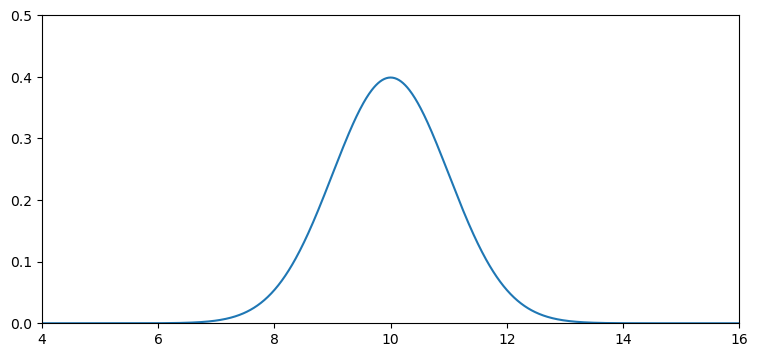

In [3]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., 
                        xlim=(4, 16), ylim=(0, .5));

这个图描绘了我们对狗的位置的不确定性。它代表了一种相当不准确的信念。虽然我们认为狗最有可能在 10 m 处，但 9 m 到 11 m 左右的任何位置也很有可能。假设狗站着不动，我们再次查询传感器。这次它返回 10.2 m。我们可以使用这些额外的信息来改进我们的估计吗？

直觉表明我们可以。考虑一下：如果我们读取传感器 500 次，每次它返回一个介于 8 和 12 之间的值，都以 10 为中心，我们应该非常确信狗接近 10。当然，可以有不同的解释。也许我们的狗以一种完全模拟正态分布随机抽取的方式随机来回徘徊。但这似乎极不可能——我从未见过狗这样做。让我们看看做500次实验，基于$\mathcal N(10, 1)$：



Mean of readings is 10.010


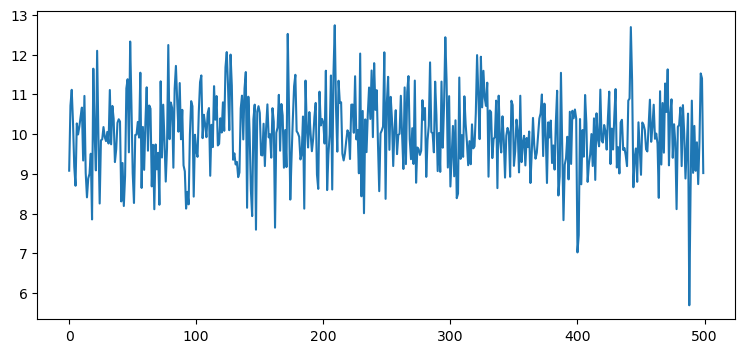

In [4]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1. + 10.
plt.plot(xs, ys)
print(f'Mean of readings is {np.mean(ys):.3f}')

目测这证实了我们的直觉——没有狗像这样移动。然而，嘈杂的传感器数据肯定是这样的。读数的计算平均值几乎正好是 10。假设狗站着不动，我们说狗在位置 10，方差为 1。

## 三、使用高斯概率进行跟踪
